In [1]:
import os
import sys
import pathlib

module_path = os.path.abspath(os.path.join('../../'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import jax
import jax.numpy as jnp
import jax.random as rnd

import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from rationality import dynamics as dyn, objectives as obj, distributions as dst,\
    controllers as ctl, simulate as sim, util as util

Set up plotting configuration.

In [3]:
pathlib.Path('figures/').mkdir(parents=True, exist_ok=True)

plt.style.reload_library()
plt.style.use(['science', 'notebook'])

%config InlineBackend.figure_format = 'svg'

figure_formats = ['png', 'eps', 'svg', 'pdf', 'pgf']


In [4]:
relative_noise_stds = jnp.array([0.25, 0.25, 0.1, 0.25, 0.25, 0.1])
noise_scale_coeffs = jnp.array([3.0, 2.0, 1.0, 0.0])

Control problem parameters.

In [5]:
horizon = 12
dt = 0.3  # try ~0.2

Q = 0.1 * jnp.eye(6)
R = 0.01 * jnp.eye(2)
Qf = 10 * jnp.eye(6)

ic = jnp.array([1.0, -1.0, 0.0, 0.0, 0.0, 0.0])
ic_cov = jnp.diag(jnp.array([1e-1, 1e-1, 1e-3, 1e-2, 1e-2, 1e-4]) ** 2)

The values of $\beta$ to sweep through.

In [6]:
inv_temps = 10 ** (jnp.linspace(1, 2.7, 50))

Create problem data structures.

In [7]:
objective = obj.quadratic(Q, R, Qf)
dynamics = dyn.crazyflie2d(dt)
linearized_dynamics = dyn.linear(*dyn.linearize(dynamics, jnp.zeros(6),
                                                jnp.array([dynamics.params.hover_force, 0.0]), 0))

prob = ctl.problem(linearized_dynamics, objective, horizon)

Compute the exact expected cost of the control problem.

In [8]:
lqr = ctl.lqr.create(prob)

print(f'Optimal Problem Value: {ctl.lqr.cost_to_go(prob, ic, ic_cov)}')

Optimal Problem Value: 0.6307664513587952


Setup the bounded-rationality controller and simulation.

In [9]:
noise_cov = jnp.transpose(jnp.tile(jnp.diag(relative_noise_stds), (horizon + 1, 1, 1)), (1, 2, 0))

key = rnd.PRNGKey(0)
key, subkey = rnd.split(key)

prior_params = ctl.lqr.input_stats(prob, ic, ic_cov)
prior_params = dst.GaussianParams(prior_params.mean, prior_params.cov)
lqbr = ctl.lqbr.create(prob, prior_params, 1.0)
lqbr_sim = sim.compile_simulation(prob, lqbr)

ctg_part_obs = jax.jit(
    lambda beta, scale: ctl.lqbr.cost_to_go(prob, ctl.lqbr.LQBRParams(beta, prior_params), ic, ic_cov,
                                            (scale ** 2) * noise_cov[:, :, :-1]))


Compute expected cost for different values of $\beta$ and $\sigma^2_{\hat{x}}$.

In [10]:
noise_coeffs = jnp.array([0.0, 1.0, 2.0, 3.0])

expected_problem_value = jax.vmap(lambda s: jax.vmap(lambda it: ctg_part_obs(it, s))(inv_temps), out_axes=-1)(noise_coeffs)
best_inv_temps = inv_temps[jnp.argmin(expected_problem_value, axis=0)]
best_expected_costs = expected_problem_value.min(axis=0)

lqr_expected_costs = jax.vmap(lambda s: ctl.lqr.cost_to_go(prob, ic, ic_cov, (s ** 2) * noise_cov[:, :, :-1]))(noise_coeffs)

Plot results:


In [11]:
def set_size(w=None, h=None, ax=None):
    """ w, h: width, height in inches """
    if not ax:
        ax = plt.gca()

    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom

    figw = float(w) / (r - l) if w is not None else (r - l)
    figh = float(h) / (t - b) if h is not None else (t - b)

    ax.figure.set_size_inches(figw, figh)

<ipython-input-13-9ea06f695b66>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['', '$\infty$', ''])


Saving PNG format: figures/log-beta-expectation-analytic-with-inf.png
Saving EPS format: figures/log-beta-expectation-analytic-with-inf.eps
Saving SVG format: figures/log-beta-expectation-analytic-with-inf.svg
Saving PDF format: figures/log-beta-expectation-analytic-with-inf.pdf
Saving PGF format: figures/log-beta-expectation-analytic-with-inf.pgf


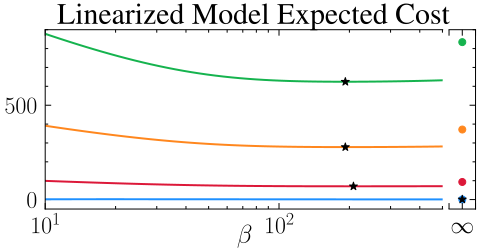

In [13]:
colors = ['#1E90FF', '#DC1839', '#FF871E', '#15B34E']
color_cycler = cycler.cycler(color=colors)

# Weird bug in EPS file if I don't load then unload IEEE mode...
plt.style.use(['science', 'ieee', 'notebook'])
plt.style.use(['science', 'notebook'])

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='times')
plt.rc('axes', prop_cycle=color_cycler)
plt.rc('text.latex', preamble='\\usepackage{lmodern}\n\\renewcommand{\\rmdefault}{ptm}')


f, ax = plt.subplots(1, 2, sharey=True,
                     gridspec_kw={'width_ratios': [15, 1]})

for i, scale in enumerate(noise_coeffs):
    ax[0].plot(inv_temps, expected_problem_value[:, i])
    ax[1].scatter(0, lqr_expected_costs[i], s=50)

    if i > 0:
        ax[0].scatter(best_inv_temps[i], expected_problem_value[:, i].min(), s=70, c='k', marker='*', zorder=3)

ax[0].set_xlim([10, 10 ** 2.7])
ax[0].set_ylim([-50, 900])
ax[0].spines['right'].set_visible(False)
ax[0].tick_params(axis='y', which='both', right=False)
ax[0].tick_params(axis='both', which='major', pad=8.0, labelsize=24)
ax[0].set_xscale('log')

ax[1].scatter(0.0, expected_problem_value[:, 0].min(), s=70, c='k', marker='*', zorder=3)
ax[1].set_xlim([-0.5, 0.5])
#ax[1].set_xticks([1.0])
ax[1].set_xticklabels(['', '$\infty$', ''])
ax[1].tick_params(axis='x', which='minor', bottom=False, top=False)
ax[1].tick_params(axis='x', which='major', pad=8.0, labelsize=24)

ax[1].tick_params(axis='y', which='both', left=False)
ax[1].spines['left'].set_visible(False)


set_size(6, 2.5, ax[0])


ax[0].set_xlabel('$\\beta$', fontsize=26, labelpad=-13)
f.suptitle('Linearized Model Expected Cost', fontsize=30, y=0.99)
f.subplots_adjust(wspace=0.03)

util.savefig('figures/log-beta-expectation-analytic-with-inf', figure_formats)